# Face Recognition with Eigenfaces and DLIB

In this exercise, we will explore two different methods for face recognition to compare classical and deep learning approaches. The first method will be a classical approach based on Eigenfaces, and the second will be a deep learning approach using DLIB.

# Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Loading the dataset

We use the Labeled Faces in the Wild (LFW) people dataset from sklearn, which is a database of aligned grayscale face photographs. It contains 13,233 images of 5,749 people. Each image is centered on a single face. 

We will filter the dataset using `min_faces_per_person=10`, which will leave us with 1183 images of 22 people.

### Task 1: Load the dataset and visualize images

In [2]:
faces = fetch_lfw_people(min_faces_per_person=10, color=True)

X = faces.images
y = faces.target

IMG_H = X.shape[1]
IMG_W = X.shape[2]
N_IDENTITIES = faces.target_names.shape[0]

# TODO: Split the data into a training and testing set, with 20% of the data for testing. Use a random_state of 42.
# Hint: use train_test_split from sklearn.model_selection (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'{X_train.shape=}')
print(f'{X_test.shape=}')
print(f'{y_train.shape=}')
print(f'{y_test.shape=}')
print('Number of identities:', N_IDENTITIES)

X_train.shape=(3459, 62, 47, 3)
X_test.shape=(865, 62, 47, 3)
y_train.shape=(3459,)
y_test.shape=(865,)
Number of identities: 158


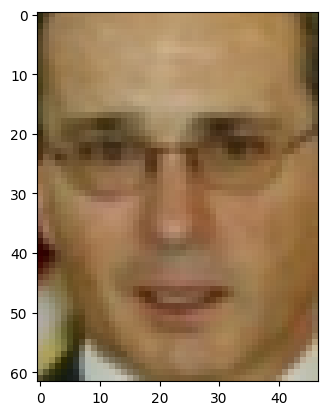

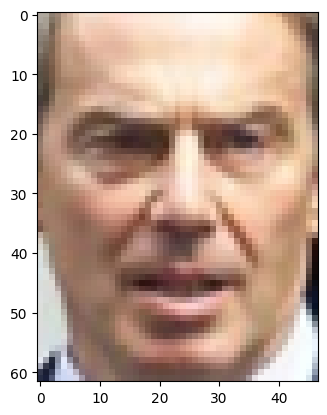

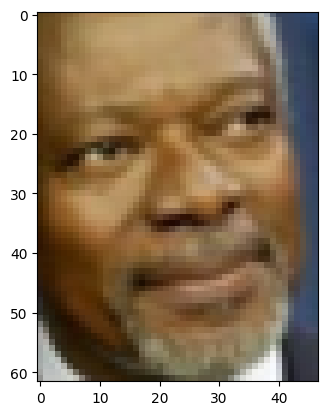

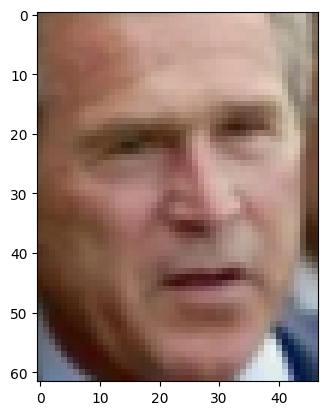

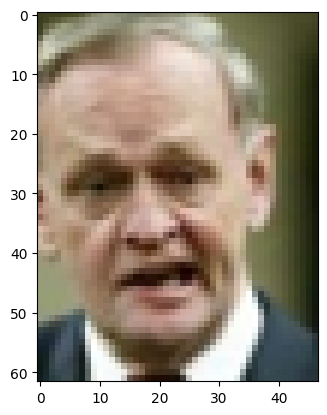

In [3]:
# TODO: visualize some images
# Hint: use plt.imshow (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)

X_train_sample = X_train[:5]
for sample in X_train_sample:
    plt.imshow(sample)
    plt.show()

## Eigenfaces

Paper: https://direct.mit.edu/jocn/article/3/1/71/3025/Eigenfaces-for-Recognition

Eigenfaces is a classical approach to face recognition. It is based on principal component analysis (PCA), which is a linear dimensionality reduction technique. The idea behind PCA is to find a lower-dimensional representation of a dataset that contains as much information as possible but with fewer features. In our case, each image is a data point with 62*47*3=8742 features. We will use PCA to reduce the dimensionality of the dataset to 150 features.

For the purposes of this exercise, you can think of PCA as simply a classical featurizer. It takes a single image as an input, and outputs a vector of 150 features which we can then use to determine if two images are of the same person.

For the classifier, we will use a Linear Support Vector Classifier (LinearSVC). This is a linear classifier that uses the support vector machine (SVM) algorithm. Essentially, it finds optimal hyperplanes that separate the data points into classes.

In [5]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

### Your Tasks:

1. Create a PCA featurizer with 150 components (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
2. Create a LinearSVC classifier (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
3. Create a model using `make_pipeline` (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)
4. Fit the model to the training data using `model.fit`
5. Evaluate the model on the test data using `model.score`

Hints:
1. Training and testing data must be in the shape (n_samples, n_features), you may need to reshape the data.

In [9]:
# Use PCA to reduce the dimensionality of the data and consider only the most important features
pca = PCA(n_components=150)

# Use a linear support vector classifier to classify the faces
svc = LinearSVC()

# Combine the two into a single pipeline for simplicity
model = make_pipeline(pca, svc)

# Note: need to reshape data for PCA in the shape (n_samples, n_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], IMG_W * IMG_H * 3) 
X_test_reshaped = X_test.reshape(X_test.shape[0], IMG_W * IMG_H * 3)

# Fit the model to the training data
model.fit(X_train_reshaped, y_train)

# Evaluate the model
accuracy = model.score(X_test_reshaped, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.45895953757225433


We should be getting around 70% accuracy with this model. This is pretty good and way better than random! However, we still make mistakes about 30% of the time and can do a lot better with a deep learning approach.

# Now let's try a deep learning approach with DLIB

DLIB is a C++ library with Python bindings that contains implementations of many popular computer vision algorithms. It is a very powerful library, and we will only be using a small part of it for this exercise.

DLIB has a pre-trained face recognition model. It is a deep convolutional neural network (CNN) that takes in an image of a face and outputs a 128-dimensional vector, or latent. The idea is that if two images are of the same person, the distance between the two vectors will be small. If the images are of different people, the distance will be large.

We're going to use the `face_recognition` library to work with DLIB and perform face recognition.

In [11]:
import face_recognition

The `face_recognition` library has a function `face_encodings` that takes in an image and returns the 128-dimensional vector. We can use this to featurize our images. To call it, we need to provide the images and the bounding boxes of the faces in the images. Since we know that there is only one face in each image and they're aligned, we can just use the entire image as the bounding box as follows:

```python
face_locations = (0, IMG_W, IMG_H, 0)
face_encodings = face_recognition.face_encodings(image, face_locations)
```

Our pipeline for face recognition will be be the same as before, except instead of PCA we'll use `face_recognition` to featurize the images. The classifier will still be the same, a LinearSVC, trained on the image embeddings.

In [ ]:
face_locations = [(0, IMG_W, IMG_H, 0)]

# TODO: convert images into the right format (0-255, 8-bit unsigned integers)
imgs_train = (X_train * 255.0).astype(np.uint8)
imgs_test = (X_test * 255.0).astype(np.uint8)

train_embs = np.zeros((len(imgs_train), 128))
for i, img in enumerate(imgs_train):
    # TODO: compute the embeddings for the training images
    train_embs[i] = face_recognition.face_encodings(img, known_face_locations=face_locations)[0]

# TODO: create and train a linear support vector classifier (LinearSVC) on the embeddings (train_embs) and the labels (y_train)
svc = LinearSVC()
svc.fit(train_embs, y_train)

# TODO: compute the accuracy on the test set. Make sure to featurize the test images first, the same as the training images
test_embs = np.zeros((len(imgs_test), 128))
for i, img in enumerate(imgs_test):
    test_embs[i] = face_recognition.face_encodings(img, known_face_locations=face_locations)[0]
accuracy = model.score(test_embs, y_test)
print(f'Accuracy: {accuracy}')

This is a lot better!